In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings

#remove warning messages that are annoyting >:(
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv('raw_datasets/df_Counties2020.csv')
df = df[(df['Countyname'] == 'Dallas') & (df['ST_Name'] == 'Texas')]
df.head()

,Unnamed: 0,Countyname,ST_Name,FIPS,ST_ID,dt,Confirmed,Deaths,Population,IncidenceRate,NewCases
1276028,2756,Dallas,Texas,48113,48,2020-01-22,0,0,2635516,0.0,0.0
1276029,6098,Dallas,Texas,48113,48,2020-01-23,0,0,2635516,0.0,0.0
1276030,9440,Dallas,Texas,48113,48,2020-01-24,0,0,2635516,0.0,0.0
1276031,12782,Dallas,Texas,48113,48,2020-01-25,0,0,2635516,0.0,0.0
1276032,16124,Dallas,Texas,48113,48,2020-01-26,0,0,2635516,0.0,0.0


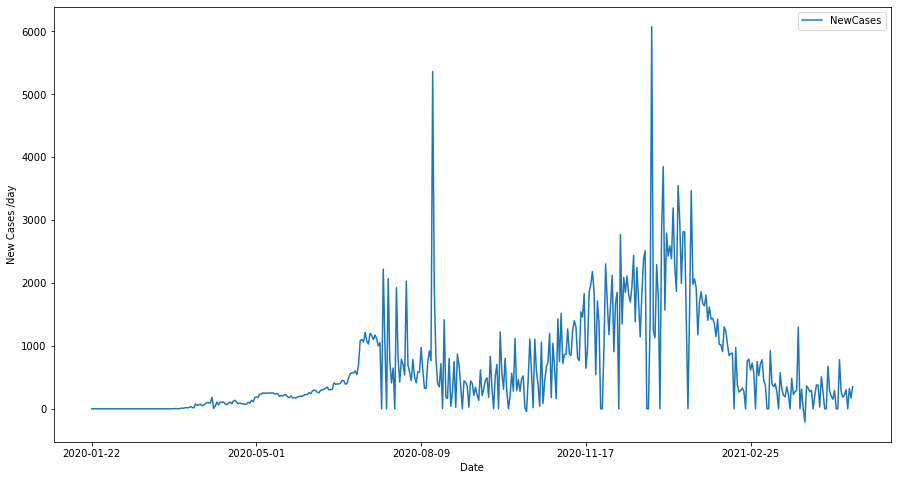

In [7]:
df.plot('dt','NewCases', figsize=(15,8))
plt.xlabel('Date')
plt.ylabel('New Cases /day')
plt.show()

In [17]:
df.to_csv('clean_datasets/Dallas_cases.csv')